
# Python interface for thin shells
```
This file is part of the G+Smo library.

This Source Code Form is subject to the terms of the Mozilla Public
License, v. 2.0. If a copy of the MPL was not distributed with this
file, You can obtain one at http://mozilla.org/MPL/2.0/.

Author(s): H.M. Verhelst
```
## Prerequisites & Dependencies
This example relies on the `pybind11` interface of G+Smo. This means that you need to have `pybind11` installed in python:
```
pip install pybind11
```
Furthermore, the Kirchhoff-Love shell library is used. Therefore, build G+Smo with the following settings.
```
cd <build directory>
cmake . -DGISMO_PYBIND11=ON -DGISMO_KLSHELL=ON
make pygismo
```
If CMake cannot find `pybind11`, run the following
```
exportpybind11_DIR=<path to pybind11>
```
You can find the paths to installed packages of python by calling
```
python -m site
```
Then find `pybind11` in on of these locations and give this ar the `<path to pybind11>`



## Preamble

In [14]:
# Required for finding pygismo
import os, sys
# Obtain pygismo
gismo_path=os.path.join(os.getcwd() , "../../../")
print("G+Smo path:",gismo_path,"(change if needed).")
sys.path.append(gismo_path+"build/lib")

# Import pygismo
import pygismo as gs ## If this line gives an error, check your path or check if pygismo is compiled

# Import other modules
import numpy as np
import scipy.sparse.linalg as la
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# for creating a responsive plot
# %matplotlib widget
%matplotlib inline

import scipy.optimize as opt


G+Smo path: /home/hverhelst/Documents/gismo_stable/extensions/gsKLShell/python_examples/../../../ (change if needed).


## Initialization of geometry and material

#### Make a geometry

In [15]:
c1 = np.array([0.,0.,1.,1.])
c2 = np.array([0.,0.,1.,1.])
ku1 = gs.nurbs.gsKnotVector(c1,1)
ku2 = gs.nurbs.gsKnotVector(c2,1)

coefs = np.array([
                    [0     ,0    ,0   ],
                    [2     ,0    ,0   ],
                    [0     ,2    ,0   ],
                    [2     ,2    ,0   ],
                        ])


# Construct basis using knot vectors
tbasis1 = gs.nurbs.gsTensorBSplineBasis2(ku1,ku2)
tspline1 = gs.nurbs.gsTensorBSpline2(tbasis1,coefs)

### Define the multipatch object and refine and elevate

In [16]:
mp = gs.core.gsMultiPatch()
mp.addPatch(tspline1)

# elevate the degree (starts at 1)
mp.degreeElevate()     #degree = 2
# mp.degreeElevate()     #degree = 3
mp.uniformRefine()     # 4 elements
mp.uniformRefine()     # 16 elements
mp.uniformRefine()     # 32 elements

# multibasis
mb = gs.core.gsMultiBasis(mp)

# store the coefficients
coefs = mp.patch(0).coefs()

### Define the shell characteristics

In [17]:
# thickness
t = gs.core.gsFunctionExpr("0.02",3)
# Young's modulus
E = gs.core.gsFunctionExpr("10e6",3)
# Poisson's ratio
nu = gs.core.gsFunctionExpr("0.3",3)
# Surface force
f = gs.core.gsFunctionExpr("0","0","0",3)
# Point loads
pload = gs.pde.gsPointLoads()
pload.addLoad(np.array([0.5,0.5]),np.array([0,0,-1]),0,True)

### Define boundary conditions

In [18]:
bcs = gs.pde.gsBoundaryConditions();
for corner in [gs.core.corner.northwest, 
             gs.core.corner.northeast, 
             gs.core.corner.southwest, 
             gs.core.corner.southeast]:
    bcs.addCornerValue(corner,0.0,0,0,-1) # corner, value, patch, unknown, component
        
# assign the geometry to the boundary conditions
bcs.setGeoMap(mp) 

### Define material matrix and solver

In [21]:
mm = gs.klshell.gsMaterialMatrixLinear3(mp,t)
mm.setYoungsModulus(E)
mm.setPoissonsRatio(nu)

assembler = gs.klshell.gsThinShellAssembler3(mp,mb,bcs,f,mm)
assembler.setPointLoads(pload)

AttributeError: 'pygismo.klshell.gsThinShellAssembler3' object has no attribute 'setPointLoads'

### Solve

In [20]:
assembler.assemble()
matrix = assembler.matrix()
vector = assembler.rhs()
solution = la.spsolve(matrix,vector[:,0])

def Residual(resvec):
        sol = assembler.constructSolution(resvec)
        assembler.assembleVector(sol)
        return assembler.rhs()

def Jacobian(resvec):
    sol = assembler.constructSolution(resvec)
    assembler.assembleMatrix(sol)
    return assembler.matrix()

residual = np.linalg.norm(vector)
residual0 = residual
residualOld = residual
update = solution
resvec = Residual(solution)

itmax = 100
tol = 1e-6
for it in range(0,itmax):
    jacmat = Jacobian(solution)
    update = la.spsolve(jacmat,resvec[:,0])
    solution += update

    resvec = Residual(solution)
    residual = np.linalg.norm(resvec)

    print("Iteration ",it,end="")
    print(", residue %0.5e" %residual,end="")
    print(", update norm %0.5e" %np.linalg.norm(update),end="")
    print(", log(Ri/R0) %0.5e" %np.log(residualOld/residual0),end="")
    print(", log(Ri+1/R0) %0.5e" %np.log(residual/residual0),end="")
    print("")

    residualOld = residual

    if (np.linalg.norm(update) < tol):
        break
    elif (it+1==itmax):
        print("Maximum iterations reached")


# Constructs the displacement
def constructDisplacement(solVec):
    return assembler.constructDisplacement(solVec)

# Constructs the displaced shell
def constructSolution(solVec):
    return assembler.constructSolution(solVec)



Iteration  0, residue 0.00000e+00, update norm 0.00000e+00, log(Ri/R0) nan, log(Ri+1/R0) nan


/tmp/ipykernel_488362/91211210.py:35: RuntimeWarning: invalid value encountered in double_scalars
  print(", log(Ri/R0) %0.5e" %np.log(residualOld/residual0),end="")
/tmp/ipykernel_488362/91211210.py:36: RuntimeWarning: invalid value encountered in double_scalars
  print(", log(Ri+1/R0) %0.5e" %np.log(residual/residual0),end="")


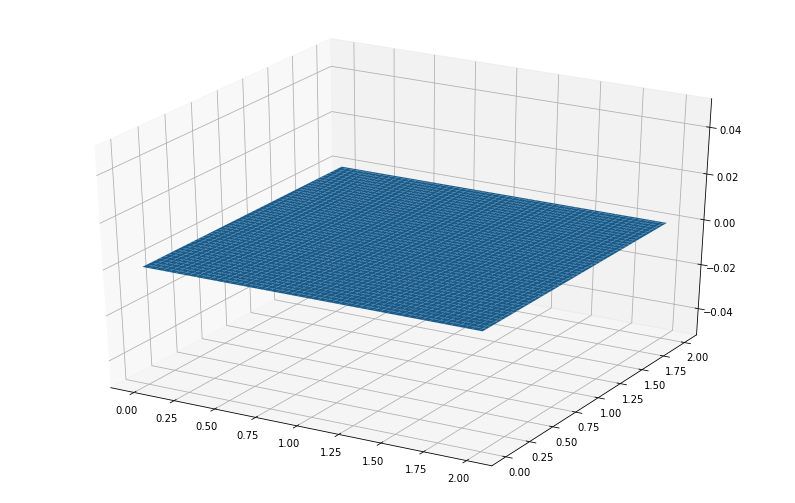

In [9]:
# Plots the geometry
fig = plt.figure(figsize =(14, 9))
ax = fig.add_subplot(projection ='3d')

nx = ny = 100
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x,y,indexing='xy')
pts = np.stack((xv.flatten(),yv.flatten()))
geom = mp.patch(0).eval(pts)
x = geom[0,:].reshape(nx,ny)
y = geom[1,:].reshape(nx,ny)
z = geom[2,:].reshape(nx,ny)
ax.plot_surface(x,y,z)

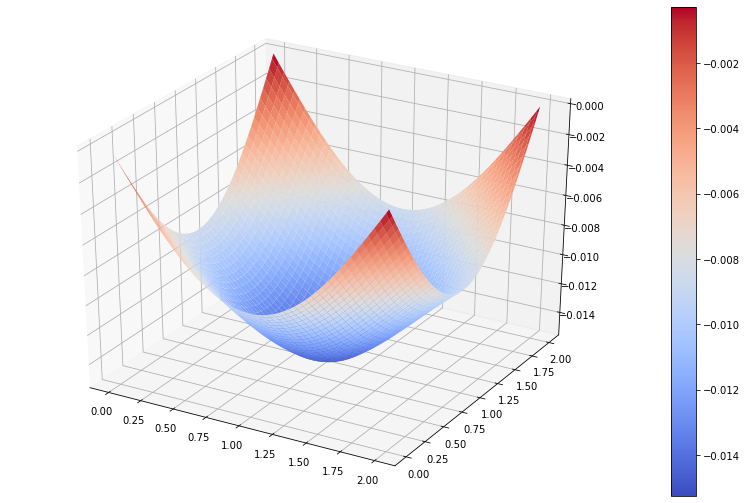

In [10]:
# Plots the deformed geometry
fig = plt.figure(figsize =(14, 9))
ax = fig.add_subplot(projection ='3d')

mp_def = constructSolution(solution)
nx = ny = 100
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x,y,indexing='xy')
pts = np.stack((xv.flatten(),yv.flatten()))

deformed = mp_def.patch(0).eval(pts)
XX = deformed[0,:].reshape((nx,ny))
YY = deformed[1,:].reshape((nx,ny))
ZZ = deformed[2,:].reshape((nx,ny))
p = ax.plot_surface(XX,YY,ZZ,cmap=cm.coolwarm)
fig.colorbar(p)